In [6]:
import pandas as pd
import numpy as np

## Plan:
- Use a pre-trained model for feature extraction
- Make pre-trained/homemade model for feature processing
- Compute 20*20 sine/cosine similarity matrix
- Select top 2 images most similar to 'left' image

### Preprocess and show

In [7]:
# Import train and test data
test_candidates = pd.read_csv('test_candidates.csv')
train_candidates = pd.read_csv('train_candidates.csv')
train_true = pd.read_csv('train.csv')
train_true.head()

,left,right
0,aaa,osr
1,aaz,mqw
2,abh,cdx
3,abn,uzp
4,abq,bbd


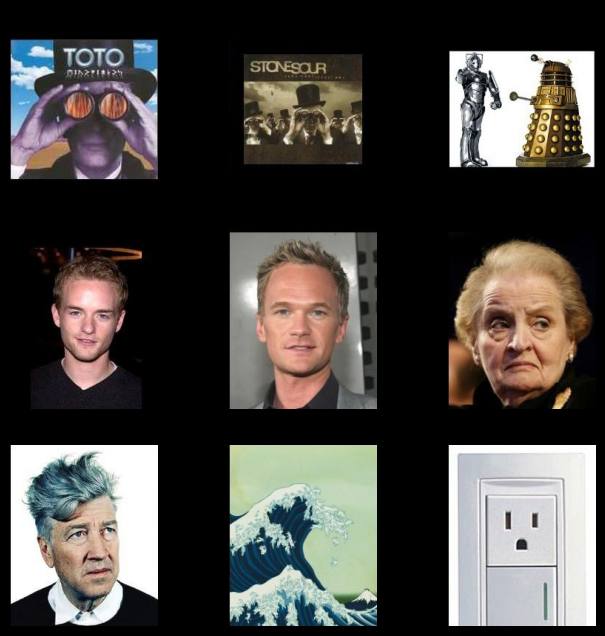

In [64]:
# Visualize Pair of matching images + a rdm image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

def preprocess_image(image):
    """Original images are 200x245, normalize and downsample image to 40x49"""
    image = image.astype(np.float32) / 255.
    return image[::5, ::5]

def show(ax, fig, image_path, with_preprocess=True):
    img = mpimg.imread(image_path)
    if with_preprocess:
        img = preprocess_image(img)
    ax.imshow(img)
    ax.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(8, 8), facecolor='black')

for i in range(3):
    left, right = train_true.iloc[i]
    # Pair of matching images
    show(axs[i, 0], fig, 'train/all/{}.jpg'.format(left))
    show(axs[i, 1], fig, 'train/all/{}.jpg'.format(right))
    # random image from the train set (not a true match)
    rd_img = random.sample(list(train_candidates.iloc[i].where(lambda x: ~x.isin([left, right])).dropna()), 1)[0]
    show(axs[i, 2], fig, 'train/all/{}.jpg'.format(rd_img))

### Cosine similarity

In [61]:
# compute cosine similartiy matrix between first image of train_candidates
# and all 20 images of the same row
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(row, with_preprocessing=True):
    """Compute cosine similarity between first image of row and all other images in row"""
    left = row.iloc[0]
    right = row.iloc[1:]
    
    # Using downsampled 40x49 images gives a very close cosine similarity to the original 200x245 images
    if with_preprocessing:
        left = preprocess_image(mpimg.imread('train/all/{}.jpg'.format(left))).flatten()
        right = [preprocess_image(mpimg.imread('train/all/{}.jpg'.format(img))).flatten() for img in right]
    else: 
        left = mpimg.imread('train/all/{}.jpg'.format(left)).flatten()
        right = [mpimg.imread('train/all/{}.jpg'.format(img)).flatten() for img in right]

    left = left.reshape(1, -1)
    right = np.array(right)
    return left, right, cosine_similarity(left, right)[0]

In [62]:
left, right, sim_matrix = compute_cosine_similarity(train_candidates.loc[0])
pred_ind = np.argmax(sim_matrix)
true_row_ind = row_idx = (train_candidates.iloc[0] == train_true.iloc[0, 1]).idxmax()
true_col_idx = list(train_candidates.columns).index(true_row_ind)
print('base img:', train_candidates.loc[0, 'left'], '/ pred:', train_candidates.loc[0, train_candidates.columns[pred_ind]], "/ dist = ", sim_matrix[pred_ind])
print('base img:', train_candidates.loc[0, 'left'], '/ true:', train_candidates.loc[0, train_candidates.columns[true_col_idx]], "/ dist = ", sim_matrix[true_col_idx])

base img: aaa / pred: vrg / dist =  0.7577027
base img: aaa / true: osr / dist =  0.3814749


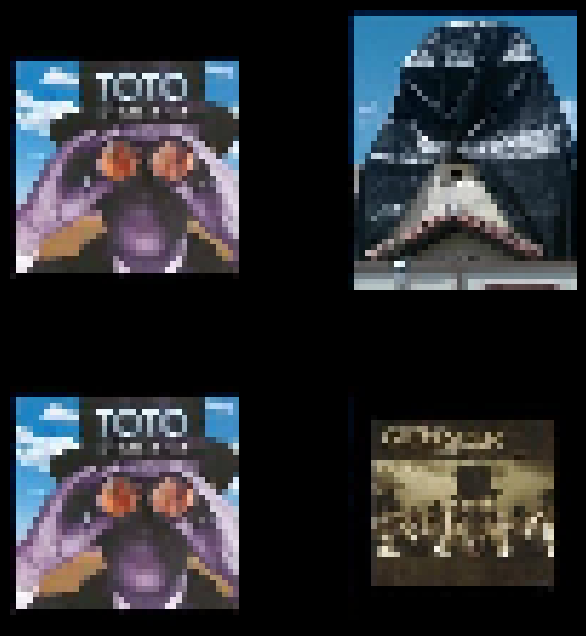

In [63]:
# Show image aaa and its most similar image
fig, axs = plt.subplots(2, 2, figsize=(8, 8), facecolor='black')
show(axs[0, 0], fig, 'train/all/{}.jpg'.format("aaa"))
show(axs[0, 1], fig, 'train/all/{}.jpg'.format(train_candidates.loc[0, train_candidates.columns[pred_ind]]))
show(axs[1, 0], fig, 'train/all/{}.jpg'.format("aaa"))
show(axs[1, 1], fig, 'train/all/{}.jpg'.format(train_candidates.loc[0, train_candidates.columns[true_col_idx]]))

### Import clip res50x4

In [ ]:
from clip import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, transform = clip.load("RN50x4", device)